example 6.2: random walk - td(0) vs monte carlo

generating figure 6.2...
running rms error experiments...
  episodes per run: 100
  independent runs: 100


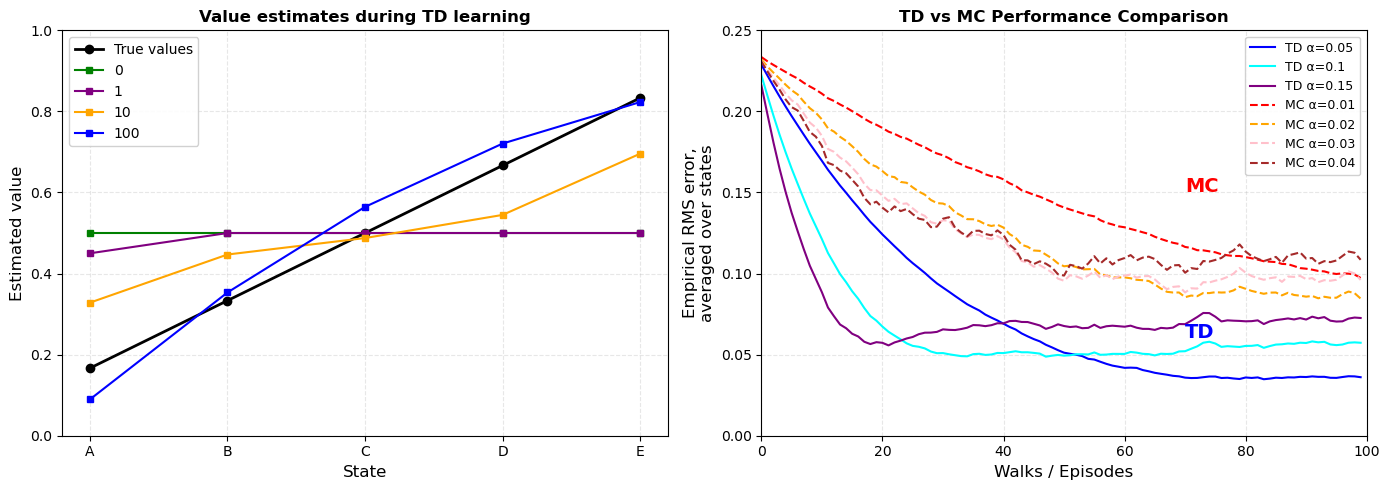

In [4]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Example 6.2
# Random Walk Markov Reward Problem
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class RandomWalkEnvironment:
    """
    random walk markov reward process
    
    sutton & barto section 6.2:
    "consider a random walk along a linear sequence of states. the walk begins
    in the center state. at each step, the walk moves either to the left or right
    by one state with equal probability. the walk terminates when it reaches either
    end of the sequence."
    
    environment structure:
    - 5 non-terminal states: A, B, C, D, E
    - 2 terminal states: left terminal and right terminal
    - agent starts in center state C
    - each step: move left or right with probability 0.5
    - reward is 0 on all transitions except terminating right (reward = 1)
    - discount factor gamma = 1 (undiscounted)
    """
    
    # state constants
    STATE_A = 0
    STATE_B = 1
    STATE_C = 2  # starting state
    STATE_D = 3
    STATE_E = 4
    
    # terminal markers
    TERMINAL_LEFT = -1
    TERMINAL_RIGHT = 5
    
    # starting position
    START_STATE = STATE_C
    
    # reward values
    REWARD_TERMINATE_RIGHT = 1.0
    REWARD_DEFAULT = 0.0
    
    def __init__(self, seed=None):
        """
        initialize random walk environment
        """
        self.rng = np.random.default_rng(seed)
        self.current_state = None
        
        # state names for printing/debugging
        self.state_names = {
            self.STATE_A: 'A',
            self.STATE_B: 'B', 
            self.STATE_C: 'C',
            self.STATE_D: 'D',
            self.STATE_E: 'E',
            self.TERMINAL_LEFT: 'LEFT',
            self.TERMINAL_RIGHT: 'RIGHT'
        }
    
    def reset(self):
        """
        start new episode
        """
        self.current_state = self.START_STATE
        return self.current_state
    
    def step(self):
        """
        take one random step in the environment
        
        from textbook section 6.2:
    	"at each step, the walk moves to one of the two neighboring states
        with equal probability. when either terminal state is reached, the
        walk terminates."
        
        """
        move_right = self.rng.random() < 0.5
        
        if move_right:
            next_state = self.current_state + 1
        else:
            next_state = self.current_state - 1
        
        # check if we reached a terminal state
        if next_state == self.TERMINAL_LEFT:
            # terminated on left - reward is 0
            reward = self.REWARD_DEFAULT
            is_terminal = True
        elif next_state == self.TERMINAL_RIGHT:
            # terminated on right - reward is 1
            reward = self.REWARD_TERMINATE_RIGHT
            is_terminal = True
        else:
            # still in non-terminal state - reward is 0
            reward = self.REWARD_DEFAULT
            is_terminal = False
            self.current_state = next_state
        
        return next_state, reward, is_terminal
    
    def get_true_values(self):
        """
        return analytically computed true state values
        
        from textbook: "the true value of each state under the random walk
        is the probability of terminating on the right if started from that state."
        
        these can be computed as:
        V(A) = 1/6, V(B) = 2/6, V(C) = 3/6, V(D) = 4/6, V(E) = 5/6
        """
        true_values = {
            self.STATE_A: 1.0/6.0,
            self.STATE_B: 2.0/6.0,
            self.STATE_C: 3.0/6.0,
            self.STATE_D: 4.0/6.0,
            self.STATE_E: 5.0/6.0
        }
        return true_values


def td_zero_prediction(env, num_episodes, alpha, initial_value=0.5):
    """
    temporal difference td(0) algorithm for value prediction

    the key update rule:
        V(S) ← V(S) + alpa[R + gammaV(S') - V(S)]
    
    called "one-step TD" because it updates based on
    one step of experience (the immediate reward + next state value estimate)
    """
    
    value_function = defaultdict(float)
    for state in range(env.STATE_A, env.STATE_E + 1):
        value_function[state] = initial_value
    
    # terminal states have value 0
    value_function[env.TERMINAL_LEFT] = 0.0
    value_function[env.TERMINAL_RIGHT] = 0.0
    
    gamma = 1.0  # discount factor (undiscounted episode)
    
    # run episodes
    for episode_idx in range(num_episodes):
        # start new episode
        current_state = env.reset()
        
        # run until terminal state
        episode_finished = False
        while not episode_finished:
            # take random step
            next_state, reward, episode_finished = env.step()
            
            # td(0) update rule:
            # V(S) ← V(S) + α[R + γV(S') - V(S)]
            td_target = reward + gamma * value_function[next_state]
            td_error = td_target - value_function[current_state]
            value_function[current_state] += alpha * td_error
            
            # move to next state
            current_state = next_state
    
    return value_function



def monte_carlo_prediction(env, num_episodes, alpha, initial_value=0.5):
    """
    constant-alpha monte carlo prediction
    
    monte carlo update rule (equation 6.1, page 120):
        V(S_t) ← V(S_t) + α[G_t - V(S_t)]
    
    where G_t is the actual return (sum of rewards) from time t onward
    
    key difference from td:
    - mc uses actual complete return G_t (needs to wait for episode  t0 end)
    - td uses estimated return R + gammaV(S') (so it can update immediately)

    """
    value_function = defaultdict(float) # initialize value function
    for state in range(env.STATE_A, env.STATE_E + 1): # set non-terminal states to initial_value
        value_function[state] = initial_value
    
    value_function[env.TERMINAL_LEFT] = 0.0
    value_function[env.TERMINAL_RIGHT] = 0.0
    
    gamma = 1.0  # discount factor
    
    # run episodes
    for episode_idx in range(num_episodes):
        # gen complete episode
        episode_states = []
        episode_rewards = []
        
        # start episode
        current_state = env.reset()
        episode_states.append(current_state)
        
        # run until terminal
        episode_finished = False
        while not episode_finished:
            next_state, reward, episode_finished = env.step()
            episode_rewards.append(reward)
            
            if not episode_finished:
                episode_states.append(next_state)
            
            current_state = next_state
        
        # now update values using actual returns
        # work backwards from end of episode
        cumulative_return = 0.0
        
        # process each state visited in reverse order
        for step_idx in range(len(episode_states) - 1, -1, -1):
            state_visited = episode_states[step_idx]
            reward_received = episode_rewards[step_idx]
            
            # calculate return: G = gmaa*G + R
            cumulative_return = gamma * cumulative_return + reward_received
            
            # monte carlo update: V(S) ← V(S) + alpha[G - V(S)]
            mc_error = cumulative_return - value_function[state_visited]
            value_function[state_visited] += alpha * mc_error
    
    return value_function


def compute_rms_error(value_function, true_values):
    """
    compute root mean squared error between estimated and true values
    """
    squared_errors = []
    for state in true_values.keys():
        error = value_function[state] - true_values[state]
        squared_errors.append(error ** 2)
    
    mean_squared_error = np.mean(squared_errors)
    rms_error = np.sqrt(mean_squared_error)
    
    return rms_error


def run_single_training_sequence(env, method, num_episodes, alpha):
    """
    run one training sequence and track value function after each episode
    this is used to generate the left plot showing how values evolve
    """
    value_function = defaultdict(float)
    for state in range(env.STATE_A, env.STATE_E + 1):
        value_function[state] = 0.5
    value_function[env.TERMINAL_LEFT] = 0.0
    value_function[env.TERMINAL_RIGHT] = 0.0
    
    gamma = 1.0
    value_history = []
    
    for episode_idx in range(num_episodes):
        if method == 'td':
            # run one td episode
            current_state = env.reset()
            episode_finished = False
            
            while not episode_finished:
                next_state, reward, episode_finished = env.step()
                td_target = reward + gamma * value_function[next_state]
                td_error = td_target - value_function[current_state]
                value_function[current_state] += alpha * td_error
                current_state = next_state
        
        elif method == 'mc':
            # run one mc episode
            episode_states = []
            episode_rewards = []
            current_state = env.reset()
            episode_states.append(current_state)
            episode_finished = False
            
            while not episode_finished:
                next_state, reward, episode_finished = env.step()
                episode_rewards.append(reward)
                if not episode_finished:
                    episode_states.append(next_state)
                current_state = next_state
            
            # update values
            cumulative_return = 0.0
            for step_idx in range(len(episode_states) - 1, -1, -1):
                state_visited = episode_states[step_idx]
                reward_received = episode_rewards[step_idx]
                cumulative_return = gamma * cumulative_return + reward_received
                mc_error = cumulative_return - value_function[state_visited]
                value_function[state_visited] += alpha * mc_error
        
        # store snapshot of value function
        value_snapshot = {
            state: value_function[state] 
            for state in range(env.STATE_A, env.STATE_E + 1)
        }
        value_history.append(value_snapshot)
    
    return value_history


def run_experiment_for_rms_plot(alpha_values_td, alpha_values_mc, 
                                num_episodes, num_runs):
    """
    run multiple experiments to generate rms error curves for td and mc
    """
    temp_env = RandomWalkEnvironment()
    true_values = temp_env.get_true_values()
    
    # store results for each alpha
    td_errors = {alpha: np.zeros(num_episodes) for alpha in alpha_values_td}
    mc_errors = {alpha: np.zeros(num_episodes) for alpha in alpha_values_mc}
    
    # run multiple independent experiments
    for run_idx in range(num_runs):
        # use different seed for each run
        seed = run_idx
        
        # test each td alpha value
        for alpha in alpha_values_td:
            env = RandomWalkEnvironment(seed=seed)
            value_history = run_single_training_sequence(
                env, method='td', num_episodes=num_episodes, alpha=alpha
            )
            
            # compute rms error after each episode
            for episode_idx, value_func in enumerate(value_history):
                rms_err = compute_rms_error(value_func, true_values)
                td_errors[alpha][episode_idx] += rms_err
        
        # test each mc alpha value  
        for alpha in alpha_values_mc:
            env = RandomWalkEnvironment(seed=seed)
            value_history = run_single_training_sequence(
                env, method='mc', num_episodes=num_episodes, alpha=alpha
            )
            
            for episode_idx, value_func in enumerate(value_history):
                rms_err = compute_rms_error(value_func, true_values)
                mc_errors[alpha][episode_idx] += rms_err
    
    # average over all runs
    for alpha in alpha_values_td:
        td_errors[alpha] /= num_runs
    
    for alpha in alpha_values_mc:
        mc_errors[alpha] /= num_runs
    
    return td_errors, mc_errors # return restults


def plot_figure_6_2():
    """
    recreates figure 6.2 from the textbook
    
    left plot: value estimates at different points during training
    right plot: rms error comparison between td and mc
    """
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(14, 5))
    fig.patch.set_facecolor('white')
    
    # ===== LEFT PLOT: value estimates over states =====
    
    # run a single sequence to show value progression
    env_demo = RandomWalkEnvironment(seed=42)
    
    # get true values
    true_values = env_demo.get_true_values()
    
    # run td learning for demo
    num_demo_episodes = 100
    alpha_demo = 0.1
    value_history_td = run_single_training_sequence(
        env_demo, method='td', num_episodes=num_demo_episodes, alpha=alpha_demo
    )
    
    # specific episodes to plot
    episodes_to_plot = [0, 1, 10, 100]
    
    state_names = ['A', 'B', 'C', 'D', 'E']
    state_indices = list(range(5))
    
    # plot true values as horizontal line
    true_value_array = [true_values[i] for i in range(5)]
    ax_left.plot(state_indices, true_value_array, 'k-', 
                 linewidth=2, label='True values', marker='o', markersize=6)
    
    # plot est values at different points in training
    colors = ['green', 'purple', 'orange', 'blue']
    for idx, episode_num in enumerate(episodes_to_plot):
        if episode_num == 0:
            # initial values (before any learning)
            estimated_values = [0.5] * 5
            label = f'{episode_num}'
        else:
            # after episode_num episodes
            value_func = value_history_td[episode_num - 1]
            estimated_values = [value_func[state] for state in range(5)]
            label = f'{episode_num}'
        
        ax_left.plot(state_indices, estimated_values, 
                    color=colors[idx], linewidth=1.5, 
                    label=label, marker='s', markersize=5)
    
    ax_left.set_xlabel('State', fontsize=12)
    ax_left.set_ylabel('Estimated value', fontsize=12)
    ax_left.set_xticks(state_indices)
    ax_left.set_xticklabels(state_names)
    ax_left.set_ylim([0, 1])
    ax_left.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax_left.grid(True, alpha=0.3, linestyle='--')
    ax_left.set_title('Value estimates during TD learning', fontsize=12, fontweight='bold')
    
    # ===== RIGHT PLOT: rms error comparison =====
    
    # parameters for rms experiment
    alpha_values_td = [0.05, 0.1, 0.15]
    alpha_values_mc = [0.01, 0.02, 0.03, 0.04]
    num_episodes_rms = 100
    num_runs_rms = 100
    
    print("running rms error experiments...")
    print(f"  episodes per run: {num_episodes_rms}")
    print(f"  independent runs: {num_runs_rms}")
    
    td_errors, mc_errors = run_experiment_for_rms_plot(
        alpha_values_td, alpha_values_mc, num_episodes_rms, num_runs_rms
    )
    
    # plot td curves
    td_colors = ['blue', 'cyan', 'purple']
    for idx, alpha in enumerate(alpha_values_td):
        ax_right.plot(range(num_episodes_rms), td_errors[alpha],
                     color=td_colors[idx], linewidth=1.5,
                     label=f'TD α={alpha}', linestyle='-')
    
    # plot mc curves  
    mc_colors = ['red', 'orange', 'pink', 'brown']
    for idx, alpha in enumerate(alpha_values_mc):
        ax_right.plot(range(num_episodes_rms), mc_errors[alpha],
                     color=mc_colors[idx], linewidth=1.5,
                     label=f'MC α={alpha}', linestyle='--')
    
    ax_right.set_xlabel('Walks / Episodes', fontsize=12)
    ax_right.set_ylabel('Empirical RMS error,\naveraged over states', fontsize=12)
    ax_right.set_xlim([0, num_episodes_rms])
    ax_right.set_ylim([0, 0.25])
    ax_right.legend(loc='upper right', fontsize=9, framealpha=0.9)
    ax_right.grid(True, alpha=0.3, linestyle='--')
    ax_right.set_title('TD vs MC Performance Comparison', fontsize=12, fontweight='bold')
    
    # add text labels on plot
    ax_right.text(70, 0.06, 'TD', fontsize=14, fontweight='bold', color='blue')
    ax_right.text(70, 0.15, 'MC', fontsize=14, fontweight='bold', color='red')
    
    plt.tight_layout()
    plt.savefig('figure_6_2_random_walk.png', dpi=300, bbox_inches='tight', 
                facecolor='white')
    plt.show()



if __name__ == "__main__":
    print("=" * 60)
    print("example 6.2: random walk - td(0) vs monte carlo")
    print("=" * 60)
    
    # create environment and verify true values
    env = RandomWalkEnvironment()
    true_vals = env.get_true_values()
    
    
    print("\ngenerating figure 6.2...")
    plot_figure_6_2()
    